<a href="https://colab.research.google.com/github/RAFS20/Time-Series/blob/main/H2O_Series_de_Tiempo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cuaderno de: Ricardo Alonzo Fernández Salguero

In [1]:
pip install h2o

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 MB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.42.0.3-py2.py3-none-any.whl size=240945068 sha256=99aa1fbd2754bbf9b6a08796182d7dcceb3a3e5b8075918c04a0f237b796ceeb
  Stored in directory: /root/.cache/pip/wheels/f9/7d/1d/e1258f0558603969a8393cb5b22a18e313337f01627a118302
Successfully built h2o


[*********************100%%**********************]  1 of 1 completed
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.20.1" 2023-08-24; OpenJDK Runtime Environment (build 11.0.20.1+1-post-Ubuntu-0ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.20.1+1-post-Ubuntu-0ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpmkk5dev6
  JVM stdout: /tmp/tmpmkk5dev6/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpmkk5dev6/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,07 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.3
H2O_cluster_version_age:,1 month and 10 days
H2O_cluster_name:,H2O_from_python_unknownUser_ln42pw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%

Train Metrics:
R2: 0.999460296586989
RMSE: 0.38336315897448603
MAE: 0.29861035534327773
MAPE: 0.18704161362402835

Test Metrics:
R2: 0.9848082181131531
RMSE: 0.6291754287531727
MAE: 0.5745681774662953
MAPE: 0.32656618504015056


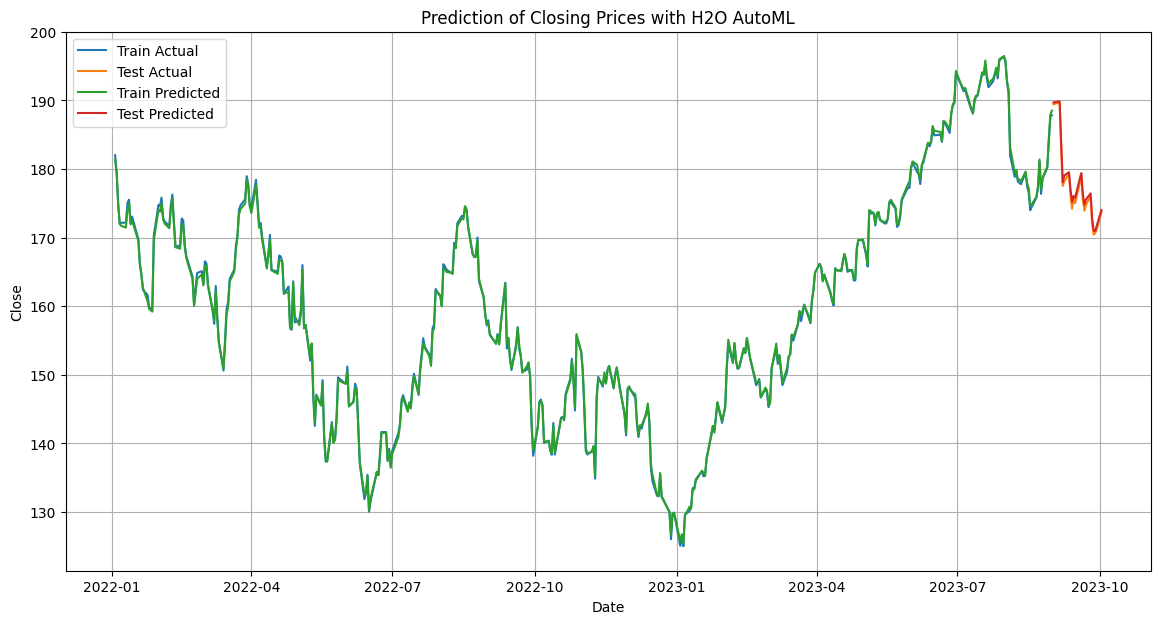

H2O session _sid_b9a0 closed.


In [2]:
import yfinance as yf
import h2o
from h2o.automl import H2OAutoML
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Constantes
TICKER = 'AAPL'
START_DATE = '2022-01-01'
END_DATE = '2023-10-03'
SPLIT_DATE = '2023-09-01'
TARGET_VARIABLE = "Close"
MAX_MODELS = 15
SEED = 1

# Función para verificar fechas
def verificar_fechas(df):
    """
    Verifica si hay fechas nulas o duplicadas en el dataframe.
    :param df: DataFrame con las fechas para verificar.
    :raise ValueError: Si se encuentran fechas no válidas.
    """
    if df.index.isnull().any() or df.index.duplicated().any():
        raise ValueError("Fechas nulas o duplicadas presentes.")
    # Más lógica de verificación según sea necesario

# Cálculo de métricas
def mape(y_true, y_pred):
    """
    Calcula el Mean Absolute Percentage Error.
    :param y_true: Valores reales.
    :param y_pred: Valores predichos.
    :return: MAPE.
    """
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def obtener_datos(ticker, start, end):
    """
    Obtiene y verifica los datos financieros.
    :param ticker: Símbolo de la acción.
    :param start: Fecha de inicio.
    :param end: Fecha final.
    :return: DataFrame con los datos.
    """
    data = yf.download(ticker, start=start, end=end)
    verificar_fechas(data)
    return data

def dividir_datos(data, split_date):
    """
    Divide los datos en conjuntos de entrenamiento y prueba.
    :param data: DataFrame con los datos.
    :param split_date: Fecha para dividir los datos.
    :return: DataFrames de entrenamiento y prueba.
    """
    train = data[data.index < split_date]
    test = data[data.index >= split_date]
    return train, test

def inicializar_y_entrenar_h2o(train, target_variable, max_models=10, seed=1):
    """
    Inicializa H2O, define las variables objetivo y predictores, entrena el modelo y retorna el modelo líder.
    :param train: DataFrame de entrenamiento.
    :param target_variable: Variable a predecir.
    :param max_models: Máximo número de modelos para AutoML.
    :param seed: Semilla para la reproducibilidad.
    :return: Modelo líder de H2O.
    """
    h2o.init()
    train_hex = h2o.H2OFrame(train)
    x = train_hex.columns
    y = target_variable
    x.remove(y)
    aml = H2OAutoML(max_models=max_models, seed=seed)
    aml.train(x=x, y=y, training_frame=train_hex)
    return aml.leader

def imprimir_metricas(name, dataset, prediction):
    """
    Imprime las métricas de evaluación para las predicciones.
    :param name: Nombre del dataset (Train/Test).
    :param dataset: Valores verdaderos.
    :param prediction: Valores predichos.
    """
    print(f"\n{name} Metrics:")
    print("R2:", r2_score(dataset, prediction))
    print("RMSE:", np.sqrt(mean_squared_error(dataset, prediction)))
    print("MAE:", mean_absolute_error(dataset, prediction))
    print("MAPE:", mape(dataset, prediction))

def visualizar_predicciones(train, test, pred_train, pred_test, target_variable):
    """
    Visualiza las predicciones y los valores reales en una gráfica.
    :param train: DataFrame de entrenamiento.
    :param test: DataFrame de prueba.
    :param pred_train: Predicciones para el conjunto de entrenamiento.
    :param pred_test: Predicciones para el conjunto de prueba.
    :param target_variable: Variable objetivo.
    """
    plt.figure(figsize=(14, 7))
    plt.plot(train.index, train[target_variable], label='Train Actual')
    plt.plot(test.index, test[target_variable], label='Test Actual')
    plt.plot(train.index, pred_train, label='Train Predicted')
    plt.plot(test.index, pred_test, label='Test Predicted')
    plt.legend()
    plt.title('Prediction of Closing Prices with H2O AutoML')
    plt.xlabel('Date')
    plt.ylabel(target_variable)
    plt.grid(True)
    plt.show()

def main():
    try:
        # Obtener y dividir datos
        data = obtener_datos(TICKER, START_DATE, END_DATE)
        train, test = dividir_datos(data, SPLIT_DATE)

        # Inicializar y entrenar modelo
        lider_modelo = inicializar_y_entrenar_h2o(train, TARGET_VARIABLE, MAX_MODELS, SEED)

        # Predicciones
        train_hex = h2o.H2OFrame(train)
        test_hex = h2o.H2OFrame(test)
        pred_train = lider_modelo.predict(train_hex).as_data_frame().values.flatten()
        pred_test = lider_modelo.predict(test_hex).as_data_frame().values.flatten()

        # Imprimir métricas
        imprimir_metricas("Train", train[TARGET_VARIABLE], pred_train)
        imprimir_metricas("Test", test[TARGET_VARIABLE], pred_test)

        # Visualización
        visualizar_predicciones(train, test, pred_train, pred_test, TARGET_VARIABLE)

    finally:
        # Asegurarse de que h2o se cierra correctamente
        h2o.cluster().shutdown(prompt=False)

if __name__ == "__main__":
    main()

[*********************100%%**********************]  1 of 1 completed
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.20.1" 2023-08-24; OpenJDK Runtime Environment (build 11.0.20.1+1-post-Ubuntu-0ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.20.1+1-post-Ubuntu-0ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmphxi4sr62
  JVM stdout: /tmp/tmphxi4sr62/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmphxi4sr62/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.3
H2O_cluster_version_age:,1 month and 11 days
H2O_cluster_name:,H2O_from_python_unknownUser_ub19gn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
R2 Train: 0.9996736259677165
R2 Test: 0.9969738100704858
RMSE Train: 0.5578940859920326
RMSE Test: 1.5864692238091136
MAPE Train: 0.3267475370285783
MAPE Test: 0.898469797695841
MSE Train: 0.3112458111848854
MSE Test: 2.5168845980934913


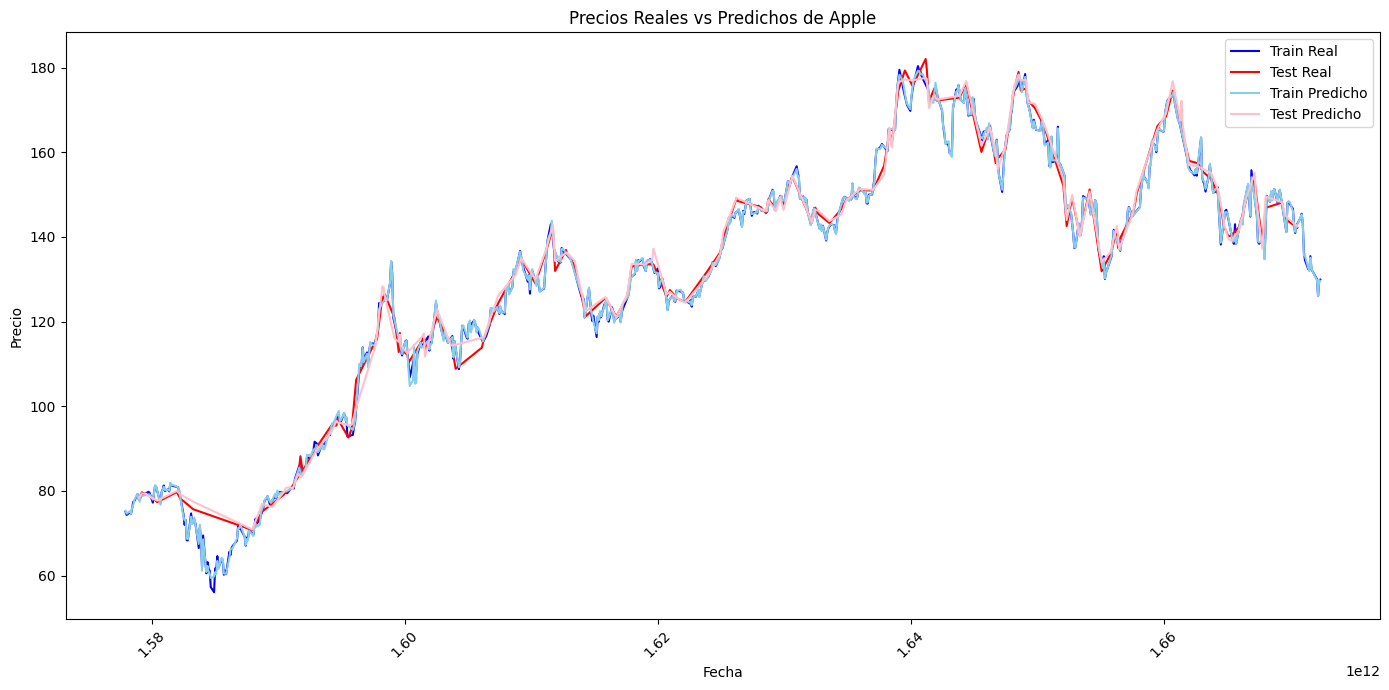

H2O session _sid_967b closed.


In [3]:
import h2o
from h2o.automl import H2OAutoML
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Descargar los datos
data = yf.download('AAPL', start='2020-01-01', end='2023-01-01')

# Resetear el índice para que la Fecha sea una columna
data = data.reset_index()

# Extraer características de la fecha
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data['Weekday'] = data['Date'].dt.weekday

# Iniciar H2O
h2o.init()

# Convertir el DataFrame de pandas a un Frame de H2O
h2o_data = h2o.H2OFrame(data)

# Dividir los datos
train, test = h2o_data.split_frame([0.8])

# Definir x e y
x = train.columns
y = "Close"
x.remove(y)

# Iniciar AutoML
aml = H2OAutoML(max_models=1, max_runtime_secs=600, seed=1)
aml.train(x=x, y=y, training_frame=train)

# Predicciones
pred_train = aml.predict(train).as_data_frame().values.flatten()
pred_test = aml.predict(test).as_data_frame().values.flatten()

# Convertir train y test a pandas DataFrame
train_df = train.as_data_frame()
test_df = test.as_data_frame()

# Métricas
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"R2 Train: {r2_score(train_df[y], pred_train)}")
print(f"R2 Test: {r2_score(test_df[y], pred_test)}")
print(f"RMSE Train: {np.sqrt(mean_squared_error(train_df[y], pred_train))}")
print(f"RMSE Test: {np.sqrt(mean_squared_error(test_df[y], pred_test))}")
print(f"MAPE Train: {mean_absolute_percentage_error(train_df[y], pred_train)}")
print(f"MAPE Test: {mean_absolute_percentage_error(test_df[y], pred_test)}")
print(f"MSE Train: {mean_squared_error(train_df[y], pred_train)}")
print(f"MSE Test: {mean_squared_error(test_df[y], pred_test)}")

# Visualización
plt.figure(figsize=(14, 7))
plt.plot(train_df['Date'], train_df[y], label='Train Real', color='blue')
plt.plot(test_df['Date'], test_df[y], label='Test Real', color='red')
plt.plot(train_df['Date'], pred_train, label='Train Predicho', color='skyblue')
plt.plot(test_df['Date'], pred_test, label='Test Predicho', color='pink')
plt.legend()
plt.title('Precios Reales vs Predichos de Apple')
plt.ylabel('Precio')
plt.xlabel('Fecha')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Finalizar H2O
h2o.cluster().shutdown()